# **RAVIR Challenge**         

Axel Romero       
*Deep Learning for Medical Image Analysis*

In [1]:
from source.data import RAVIRDataset
from source.segravir import SegRAVIRModel, Loss_Dice_CE_l2

import torch
import torch.nn as nn
from torch.nn import functional as F
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import segmentation_models_pytorch as smp
from tqdm import tqdm
from torchview import draw_graph

/media/axelrom16/HDD/AI/RAVIR_Project/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Import data**

In [2]:
train_data = RAVIRDataset(
    data_root='/media/axelrom16/HDD/AI/RAVIR_Project/data/train/training_images',
    segmentation_root='/media/axelrom16/HDD/AI/RAVIR_Project/data/train/training_masks',
    size=256,
    random_crop=False,
    interpolation="bicubic",
    n_labels=3,
    shift_segmentation=False,
    augmentation=True
)
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=2, shuffle=True)

test_data = RAVIRDataset(
    data_root='/media/axelrom16/HDD/AI/RAVIR_Project/data/train/training_images',
    segmentation_root='/media/axelrom16/HDD/AI/RAVIR_Project/data/train/training_masks',
    size=256,
    random_crop=False,
    interpolation="bicubic",
    n_labels=3,
    shift_segmentation=False,
    augmentation=True
)

In [3]:
print("Number of training samples: ", len(train_data))
print("Number of testing samples: ", len(test_data))

Number of training samples:  23
Number of testing samples:  23


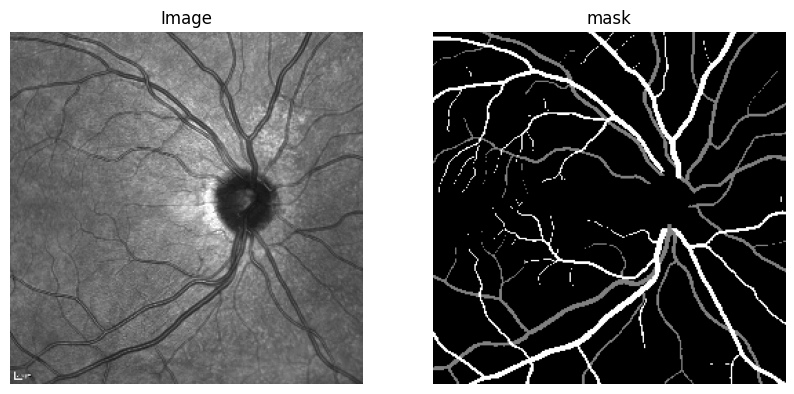

In [4]:
ex = train_data[0]

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(ex['image'])
axs[0].set_title('Image')
axs[0].axis('off')
axs[1].imshow(ex['mask'], cmap='gray')
axs[1].set_title('mask')
axs[1].axis('off')
plt.show()

## **SegRAVIR Model**

In [5]:
model = SegRAVIRModel()

print(model)

SegRAVIRModel(
  (encoder): ModuleList(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ResidualBlock(
      (conv_1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm_1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (batchnorm_2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (residual_layer): Identity()
    )
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ResidualBlock(
      (conv_1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (batchnorm_2): BatchNorm2d(32, eps=1e-

In [10]:
model_graph = draw_graph(model, input_size=(1,3,256,256), expand_nested=False)
model_graph.visual_graph.render('materials/SegRAVIR_graph', view=False)

'materials/SegRAVIR_graph.pdf'

In [7]:
print(summary(model, (3, 256, 256)))

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─Conv2d: 2-1                       [-1, 16, 256, 256]        448
|    └─ResidualBlock: 2-2                [-1, 16, 256, 256]        --
|    |    └─Conv2d: 3-1                  [-1, 16, 256, 256]        2,320
|    |    └─BatchNorm2d: 3-2             [-1, 16, 256, 256]        32
|    |    └─Dropout: 3-3                 [-1, 16, 256, 256]        --
|    |    └─Conv2d: 3-4                  [-1, 16, 256, 256]        2,320
|    |    └─BatchNorm2d: 3-5             [-1, 16, 256, 256]        32
|    |    └─Dropout: 3-6                 [-1, 16, 256, 256]        --
|    |    └─Identity: 3-7                [-1, 16, 256, 256]        --
|    └─Conv2d: 2-3                       [-1, 32, 128, 128]        4,640
|    └─ResidualBlock: 2-4                [-1, 32, 128, 128]        --
|    |    └─Conv2d: 3-8                  [-1, 32, 128, 128]        9,248
| 

In [8]:
loss_dice = smp.losses.DiceLoss(
    mode='multiclass',
    classes=[0, 1, 2]
)
loss_dice = Loss_Dice_CE_l2(
    weight_dice=0.5,
    weight_ce=0.3,
    weight_l2=0.2
)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [9]:
# Training loop
num_epochs = 40
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for example in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=True):
        image = example['image'].permute(0, 3, 1, 2).cuda()
        mask = example['mask'].permute(0, 3, 1, 2)[:, 0, ...].cuda()

        # Forward pass
        pred_mask, pred_img = model(image)
        loss = loss_dice(pred_mask, pred_img, mask, image)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print the average loss for the epoch
    average_loss = running_loss / len(train_dataloader)
    #print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}')

# Save the trained model if needed
torch.save(model.state_dict(), 'trained_model.pth')

Epoch 4/40:  17%|█▋        | 2/12 [00:00<00:00, 13.00it/s]


KeyboardInterrupt: 